# Predicting Power Outage Severity

**Name**: Issac Roy

**Website Link**: https://theboyroy05.github.io/Power-Outages/


In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime
import seaborn as sns
import requests
import folium

import plotly.express as px
pd.options.plotting.backend = "plotly"

## Step 1: Introduction


First, we'll read in the data to take a look at what we're working with


In [2]:
raw = pd.read_excel(Path("data") / "outage.xlsx")
raw.head()

,Major power outage events in the continental U.S.,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53,Unnamed: 54,Unnamed: 55,Unnamed: 56
0,Time period: January 2000 - July 2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Regions affected: Outages reported in this dat...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,variables,OBS,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,...,POPPCT_URBAN,POPPCT_UC,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND


From what we can see here, it's clear that the data needs to be cleaned before we can use it for anything. Taking a look at index 4, we can see the columns that we're working with here including month, year, state, and a multitude of other columns describing each outage.


### Brainstorming


## Step 2: Data Cleaning and Exploratory Data Analysis


In [3]:
df = (
    raw[6:]
    .reset_index(drop=True)
    .rename(columns=raw.iloc[4])
    .drop(["variables", "OBS"], axis=1)
)
df.head()

,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,OUTAGE.START.DATE,OUTAGE.START.TIME,...,POPPCT_URBAN,POPPCT_UC,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND
0,2011,7,Minnesota,MN,MRO,East North Central,-0.3,normal,2011-07-01 00:00:00,17:00:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
1,2014,5,Minnesota,MN,MRO,East North Central,-0.1,normal,2014-05-11 00:00:00,18:38:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
2,2010,10,Minnesota,MN,MRO,East North Central,-1.5,cold,2010-10-26 00:00:00,20:00:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
3,2012,6,Minnesota,MN,MRO,East North Central,-0.1,normal,2012-06-19 00:00:00,04:30:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
4,2015,7,Minnesota,MN,MRO,East North Central,1.2,warm,2015-07-18 00:00:00,02:00:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743


In [4]:
cleaned = df.copy()


def clean_datetime(row, col):
    if pd.notna(row[f"OUTAGE.{col}.DATE"]) and pd.notna(row[f"OUTAGE.{col}.TIME"]):
        return datetime.combine(
            row[f"OUTAGE.{col}.DATE"].date(), row[f"OUTAGE.{col}.TIME"]
        )


for col in ["START", "RESTORATION"]:
    cleaned[f"OUTAGE.{col}"] = df.apply(lambda row: clean_datetime(row, col), axis=1)
    cleaned.drop([f"OUTAGE.{col}.DATE", f"OUTAGE.{col}.TIME"], axis=1, inplace=True)
cleaned.head()

,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,CAUSE.CATEGORY,CAUSE.CATEGORY.DETAIL,...,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND,OUTAGE.START,OUTAGE.RESTORATION
0,2011,7,Minnesota,MN,MRO,East North Central,-0.3,normal,severe weather,NaN,...,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,2011-07-01 17:00:00,2011-07-03 20:00:00
1,2014,5,Minnesota,MN,MRO,East North Central,-0.1,normal,intentional attack,vandalism,...,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,2014-05-11 18:38:00,2014-05-11 18:39:00
2,2010,10,Minnesota,MN,MRO,East North Central,-1.5,cold,severe weather,heavy wind,...,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,2010-10-26 20:00:00,2010-10-28 22:00:00
3,2012,6,Minnesota,MN,MRO,East North Central,-0.1,normal,severe weather,thunderstorm,...,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,2012-06-19 04:30:00,2012-06-20 23:00:00
4,2015,7,Minnesota,MN,MRO,East North Central,1.2,warm,severe weather,NaN,...,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,2015-07-18 02:00:00,2015-07-19 07:00:00


In [5]:
state_geo = requests.get(
    "https://raw.githubusercontent.com/python-visualization/folium-example-data/main/us_states.json"
).json()

def plot_geo(data, legend_name):
    m = folium.Map(location=[48, -102], zoom_start=4)
    folium.Choropleth(
        geo_data=state_geo,
        name="choropleth",
        data=data,
        columns=[data.index, data],
        key_on="feature.id",
        fill_color="YlOrRd",
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name=legend_name,
    ).add_to(m)
    return m

In [6]:
plot_geo(cleaned.groupby("POSTAL.CODE").size(), legend_name="Number of Power Outages")

In [7]:
cleaned.groupby("YEAR").size().plot(
    kind="bar", title="Number of Power Outages per Year"
)

In [8]:
(
    cleaned.assign(TIME=cleaned["OUTAGE.START"].dt.strftime("%Y-%m"))
    .groupby("TIME")
    .size()
    .plot()
)

In [9]:
no_zeros = cleaned.drop(
    cleaned[
        (cleaned["DEMAND.LOSS.MW"] <= 0) & (cleaned["CUSTOMERS.AFFECTED"] <= 0)
    ].index
)

no_zeros[["DEMAND.LOSS.MW", "CUSTOMERS.AFFECTED"]].dropna().plot(
    kind="scatter",
    x="CUSTOMERS.AFFECTED",
    y="DEMAND.LOSS.MW",
    log_x=True,
    log_y=True,
    trendline="ols",
    trendline_color_override="red",
    trendline_options=dict(log_x=True, log_y=True),
)

In [10]:
pd.pivot_table(
    cleaned,
    index="CLIMATE.CATEGORY",
    columns="CLIMATE.REGION",
    values="CUSTOMERS.AFFECTED",
    aggfunc="mean",
).astype(int)

CLIMATE.REGION,Central,East North Central,Northeast,Northwest,South,Southeast,Southwest,West,West North Central
CLIMATE.CATEGORY,,,,,,,,,
cold,97364,120777,120320,63350,186070,142545,63196,171929,53500
normal,154125,154612,125290,42961,218077,164578,24918,186293,60106
warm,91868,101710,115443,118436,107234,268593,29596,231771,25250


## Step 3: Assessment of Missingness


In [11]:
cleaned.apply(lambda x: x.isna().sum()).sort_values(ascending=False).head()

HURRICANE.NAMES          1462
DEMAND.LOSS.MW            705
CAUSE.CATEGORY.DETAIL     471
CUSTOMERS.AFFECTED        443
OUTAGE.DURATION            58
dtype: int64

In [12]:
def assess_missingness_on_cause(col, plot=True):
    category_dist = cleaned["CAUSE.CATEGORY"].value_counts(normalize=True)
    missing_dist = cleaned[cleaned[col].isna()]["CAUSE.CATEGORY"].value_counts(
        normalize=True
    )

    if plot:
        fig = px.bar(pd.DataFrame({"Missing": missing_dist, "Total": category_dist}))
        fig.update_layout(barmode="group", xaxis={"categoryorder": "total descending"})
        fig.show()

    tvd = lambda x, y: np.abs(x - y).sum() / 2
    category_dist = cleaned["CAUSE.CATEGORY"].value_counts(normalize=True).values
    missing_dist = (
        cleaned[cleaned[col].isna()]["CAUSE.CATEGORY"]
        .value_counts(normalize=True)
        .values
    )
    observed = tvd(missing_dist, category_dist)

    stats = [
        tvd(
            cleaned.sample(n=cleaned[col].isna().sum())["CAUSE.CATEGORY"]
            .value_counts(normalize=True)
            .values,
            category_dist,
        )
        for _ in range(1000)
    ]

    pval = (np.array(stats) >= observed).mean()
    result = "Reject" if pval < 0.01 else "Fail to Reject"
    print(f"p-value: {pval}\nHypothesis: {result}")

In [13]:
assess_missingness_on_cause("DEMAND.LOSS.MW")

p-value: 0.0
Hypothesis: Reject


In [14]:
assess_missingness_on_cause("CAUSE.CATEGORY.DETAIL")

p-value: 0.0
Hypothesis: Reject


## Step 4: Hypothesis Testing


In [15]:
tvd = lambda x, y: np.abs(x - y).sum() / 2
uniform = np.ones(12) / 12
month_props = cleaned.value_counts("MONTH", normalize=True).values
observed = tvd(month_props, uniform)

stats = np.array([])
for _ in range(1000):
    rand = np.random.choice(12, size=cleaned.shape[0], p=uniform)
    stat = pd.Series(rand).value_counts(normalize=True)
    stats = np.append(stats, tvd(stat, uniform))

pval = (stats >= observed).mean()
result = "Reject" if pval < 0.01 else "Fail to Reject"
print(f"p-value: {pval}\nHypothesis: {result}")

p-value: 0.0
Hypothesis: Reject


## Step 5: Framing a Prediction Problem


In [16]:
def plot_monthly_average(df, cols):
    return px.line(
        df.dropna(subset=cols)
        .assign(TIME=df["OUTAGE.START"].dt.strftime("%Y-%m"))
        .groupby("TIME")[cols]
        .mean()
    )


log = lambda x: np.log(x) if x else np.nan
extra_features = cleaned.assign(
    LOG_DEMAND_LOSS_MW=cleaned["DEMAND.LOSS.MW"].apply(log),
    LOG_OUTAGE_DURATION=cleaned["OUTAGE.DURATION"].apply(log),
    LOG_CUSTOMERS_AFFECTED=cleaned["CUSTOMERS.AFFECTED"].apply(log),
    START_HR=cleaned["OUTAGE.START"].dt.hour,
    START_DAY=cleaned["OUTAGE.START"].dt.day,
    START_DAYOFWEEK=cleaned["OUTAGE.START"].dt.dayofweek,
    RESTORATION_HR=cleaned["OUTAGE.RESTORATION"].dt.hour,
    RESTORATION_DAY=cleaned["OUTAGE.RESTORATION"].dt.day,
    RESTORATION_DAYOFWEEK=cleaned["OUTAGE.RESTORATION"].dt.dayofweek,
)
plot_monthly_average(
    extra_features.query("`POSTAL.CODE` == 'CA'"),
    ["LOG_DEMAND_LOSS_MW", "LOG_OUTAGE_DURATION", "LOG_CUSTOMERS_AFFECTED"],
)

<Axes: >

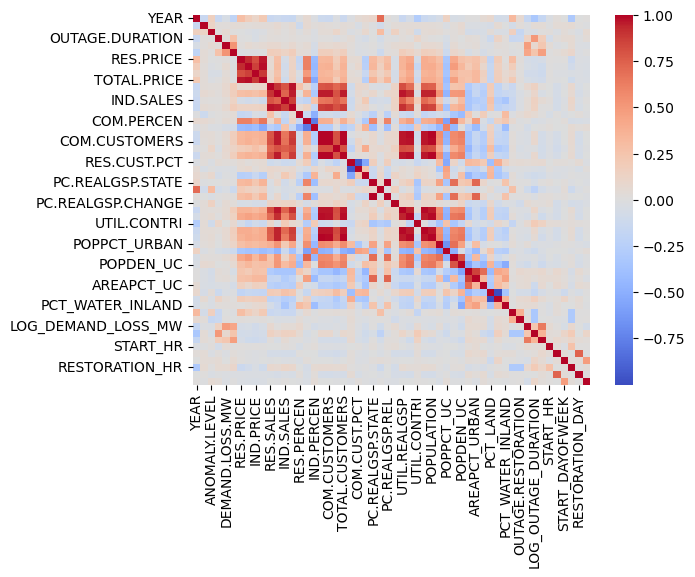

In [17]:
cat_cols = [
    "U.S._STATE",
    "POSTAL.CODE",
    "NERC.REGION",
    "CLIMATE.REGION",
    "CLIMATE.CATEGORY",
    "CAUSE.CATEGORY",
    "CAUSE.CATEGORY.DETAIL",
    "HURRICANE.NAMES",
]
corr_matrix = extra_features.drop(cat_cols, axis=1).corr()
sns.heatmap(corr_matrix, cmap="coolwarm")

In [18]:
MID = extra_features["LOG_OUTAGE_DURATION"].quantile(0.5)
fig = extra_features.plot(x="LOG_OUTAGE_DURATION", kind="hist", nbins=100)
fig.add_vline(MID, line_color="red")

In [19]:
def get_severity(row):
    if np.isnan(row["LOG_OUTAGE_DURATION"]):
        return np.nan
    if row["LOG_OUTAGE_DURATION"] > MID:
        return "HIGH"
    return "LOW"


severity = extra_features.assign(SEVERITY=extra_features.apply(get_severity, axis=1))
severity["SEVERITY"].value_counts()

SEVERITY
LOW     700
HIGH    698
Name: count, dtype: int64

In [20]:
fig = severity.plot(x="LOG_OUTAGE_DURATION", kind="hist", nbins=100, color="SEVERITY")
fig.add_vline(MID, line_color="red")

In [21]:
corr_matrix["LOG_OUTAGE_DURATION"].apply(abs).sort_values(ascending=False).iloc[1:11]

OUTAGE.DURATION           0.505447
LOG_CUSTOMERS_AFFECTED    0.353215
YEAR                      0.324978
OUTAGE.START              0.324300
OUTAGE.RESTORATION        0.322864
CUSTOMERS.AFFECTED        0.247294
LOG_DEMAND_LOSS_MW        0.231851
PC.REALGSP.USA            0.215041
RESTORATION_HR            0.201543
UTIL.CONTRI               0.200287
Name: LOG_OUTAGE_DURATION, dtype: float64

In [22]:
severity["OUTAGE.DURATION"].value_counts().head()

OUTAGE.DURATION
1       97
0       78
2880    15
60      14
300     14
Name: count, dtype: int64

In [23]:
def plot_duration(col, log_=True):
    return (
        severity.groupby(col)["OUTAGE.DURATION"]
        .median()
        .apply(log if log_ else lambda x: x)
        .sort_values(ascending=False)
        .reset_index()
        .plot(x=col, y="OUTAGE.DURATION", kind="bar")
    )

In [24]:
plot_duration("START_HR", log_=False)

## Step 6: Baseline Model


In [25]:
import plotly.graph_objects as go

def plot_accuracy_surface(grid_search):
    df = pd.DataFrame(grid_search.cv_results_)
    grouped = (
        df.groupby(["param_classifier__n_estimators", "param_classifier__max_depth"])[
            "mean_test_score"
        ]
        .max()
        .reset_index()
    )
    pivot_table = grouped.pivot(
        index="param_classifier__n_estimators",
        columns="param_classifier__max_depth",
        values="mean_test_score",
    )

    surface = go.Surface(
        z=pivot_table.values, x=pivot_table.columns, y=pivot_table.index
    )
    fig = go.Figure(data=[surface])
    fig.update_layout(
        title="Grid Search Results",
        scene=dict(
            xaxis_title="Max Depth",
            yaxis_title="Number of Estimators",
            zaxis_title="Mean Test Score",
        ),
        autosize=False,
        width=1000,
        height=800,
    )
    fig.show()

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score

cat_transformer = (
    "categorical",
    OneHotEncoder(handle_unknown="ignore"),
    ["CAUSE.CATEGORY.DETAIL", "POSTAL.CODE"],
)
preprocessor = ColumnTransformer([cat_transformer], remainder="drop")

pipeline = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("classifier", RandomForestClassifier(random_state=42)),
    ]
)

param_grid = {
    "classifier__max_depth": np.arange(1, 11),
    "classifier__n_estimators": np.arange(50, 100),
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    scoring=make_scorer(accuracy_score),
    cv=5,
    n_jobs=-1,
    verbose=1,
)

dropped_na = severity.dropna(
    subset=["CLIMATE.REGION", "CAUSE.CATEGORY.DETAIL", "SEVERITY"]
)
X = dropped_na.drop("SEVERITY", axis=1)
y = dropped_na["SEVERITY"]

grid_search.fit(X, y)
plot_accuracy_surface(grid_search)
print(f'Best score: {grid_search.best_score_}\nBest params: {grid_search.best_params_}')

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Best score: 0.6724662441443924
Best params: {'classifier__max_depth': np.int64(3), 'classifier__n_estimators': np.int64(69)}


## Step 7: Final Model


In [27]:
import numpy as np

def impute_details(df, plot=True):
    missing_detail = df["CAUSE.CATEGORY.DETAIL"].isna()
    conditional_probs = (
        df.loc[~missing_detail]
        .groupby("CAUSE.CATEGORY")["CAUSE.CATEGORY.DETAIL"]
        .value_counts(normalize=True)
        .unstack(fill_value=0)
    )

    if plot: 
        fig = conditional_probs.plot(kind="bar")
        fig.show()
    
    def sample_from_distribution(row):
        if row["CAUSE.CATEGORY"] not in conditional_probs.index: 
            return row["CAUSE.CATEGORY"]
        
        probs = conditional_probs.loc[row["CAUSE.CATEGORY"]]
        return np.random.choice(probs.index, p=probs.values)

    result = df.dropna(subset=["START_HR", "CLIMATE.REGION", "SEVERITY"])
    result.loc[missing_detail, "CAUSE.CATEGORY.DETAIL"] = df.loc[missing_detail].apply(
        sample_from_distribution, axis=1
    )

    return result

final = impute_details(severity)

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score

cat_transformer = (
    "categorical",
    OneHotEncoder(handle_unknown="ignore"),
    ["CAUSE.CATEGORY.DETAIL", "CAUSE.CATEGORY"],
)

preprocessor = ColumnTransformer(
    [
        cat_transformer,
        ("numeric", StandardScaler(), ["START_HR", "START_DAYOFWEEK"]),
    ],
    remainder="drop",
)

pipeline = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("classifier", RandomForestClassifier(min_samples_leaf=7, random_state=42)),
    ]
)

param_grid = {
    "classifier__max_depth": np.arange(1, 21, 2),
    "classifier__n_estimators": np.arange(30, 80),
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    scoring=make_scorer(accuracy_score),
    cv=5,
    n_jobs=-1,
    verbose=3,
)

X = final.drop("SEVERITY", axis=1)
y = final["SEVERITY"]
grid_search.fit(X, y)
model = grid_search.best_estimator_

plot_accuracy_surface(grid_search)
print(f'Best score: {grid_search.best_score_}\nBest params: {grid_search.best_params_}')

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Best score: 0.7817075371960496
Best params: {'classifier__max_depth': np.int64(15), 'classifier__n_estimators': np.int64(45)}


## Step 8: Fairness Analysis


In [29]:
from sklearn.metrics import confusion_matrix
import plotly.figure_factory as ff
import numpy as np

labels = ["LOW", "HIGH"]
cm = confusion_matrix(final["SEVERITY"], grid_search.predict(X), labels=labels)
cm_normalized = cm.astype('float') / cm.sum()

fig = ff.create_annotated_heatmap(
    z=cm_normalized,
    x=labels,
    y=labels,
    colorscale="deep_r",
    annotation_text=np.round(cm_normalized, 2),
)

fig.update_layout(
    xaxis_title="Predicted Label",
    yaxis_title="True Label",
    font=dict(size=14),
    yaxis=dict(autorange="reversed"),
    autosize=False,
    width=500,
    height=500,
)

fig.show()

In [30]:
recall = cm[1, 1] / (cm[1, 1] + cm[1, 0])
recall

np.float64(0.8477011494252874)

In [31]:
dropped_na = severity.dropna(subset=["CAUSE.CATEGORY.DETAIL", "SEVERITY"])

def accuracies_by_state(df):
    accuracy = lambda df: (model.predict(df.drop("SEVERITY", axis=1)) == df["SEVERITY"]).mean()
    return {
        state: accuracy(df[df["POSTAL.CODE"] == state]) 
        for state in df["POSTAL.CODE"].unique()
        if len(df[df["POSTAL.CODE"] == state])
    }

observed_accuracies = pd.Series(accuracies_by_state(dropped_na))
plot_geo(observed_accuracies, legend_name="Accuracy")
# px.histogram(pd.Series(accuracies), title="Accuracy by State")

In [32]:
from tqdm import tqdm

observed = observed_accuracies.std()
stats = np.array([])

for _ in tqdm(range(1000)):
    shuffled = dropped_na.assign(**{"POSTAL.CODE": np.random.permutation(dropped_na["POSTAL.CODE"])})
    stat = pd.Series(accuracies_by_state(shuffled)).std()
    stats = np.append(stats, stat)

pval = (stats >= observed).mean()
result = "Reject" if pval < 0.01 else "Fail to Reject"
print(f"p-value: {pval}\nHypothesis: {result}")

100%|██████████| 1000/1000 [05:48<00:00,  2.87it/s]

p-value: 0.036
Hypothesis: Fail to Reject


In [33]:
observed_wo_nebraska = observed_accuracies.drop("NE").std()
pval_wo_nebraska = (stats >= observed_wo_nebraska).mean()

fig = px.histogram(pd.Series(stats), title="Permutation Test Results")
fig.add_vline(x=observed, line_color="red", annotation_text=pval)
fig.add_vline(x=observed_wo_nebraska, line_color="blue", annotation_text=pval_wo_nebraska)
fig.show()